In [576]:
# Import libraries
import cv2
import zipfile
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import random

In [577]:
# Extract the zip file...
faces = {}

with zipfile.ZipFile("eigenface_archive.zip") as facezip:
    for filename in facezip.namelist():
        if not filename.endswith(".pgm"):
            continue       # Not a face picture
        with facezip.open(filename) as image:
            faces[filename] = cv2.imdecode(np.frombuffer(image.read(), np.uint8), cv2.IMREAD_GRAYSCALE)

In [578]:
# faces

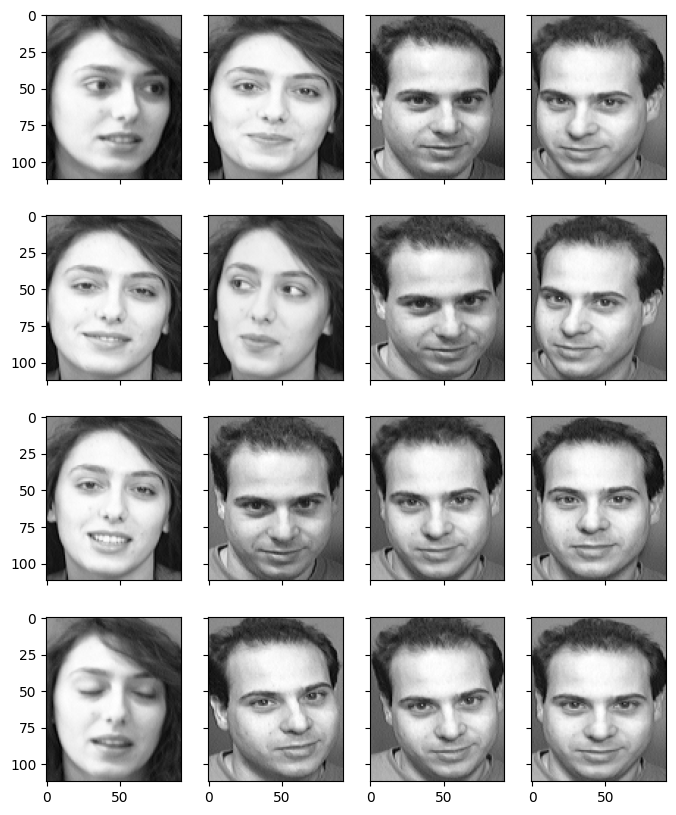

In [579]:
fig, axes = plt.subplots(4, 4, sharex=True, sharey=True, figsize=(8,10))
face_images = list(faces.values())[-16:]
for i in range(len(face_images)):
    axes[i%4][i//4].imshow(face_images[i], cmap="gray")
plt.show()

In [580]:
# Find the pixel size of each picture:
face_shape = list(faces.values())[0].shape
print(f"Face image shape: {face_shape}")

Face image shape: (112, 92)


In [581]:
faces.keys()
# print(len(faces.keys()))

dict_keys(['s1/1.pgm', 's1/10.pgm', 's1/2.pgm', 's1/3.pgm', 's1/4.pgm', 's1/5.pgm', 's1/6.pgm', 's1/7.pgm', 's1/8.pgm', 's1/9.pgm', 's10/1.pgm', 's10/10.pgm', 's10/2.pgm', 's10/3.pgm', 's10/4.pgm', 's10/5.pgm', 's10/6.pgm', 's10/7.pgm', 's10/8.pgm', 's10/9.pgm', 's11/1.pgm', 's11/10.pgm', 's11/2.pgm', 's11/3.pgm', 's11/4.pgm', 's11/5.pgm', 's11/6.pgm', 's11/7.pgm', 's11/8.pgm', 's11/9.pgm', 's12/1.pgm', 's12/10.pgm', 's12/2.pgm', 's12/3.pgm', 's12/4.pgm', 's12/5.pgm', 's12/6.pgm', 's12/7.pgm', 's12/8.pgm', 's12/9.pgm', 's13/1.pgm', 's13/10.pgm', 's13/2.pgm', 's13/3.pgm', 's13/4.pgm', 's13/5.pgm', 's13/6.pgm', 's13/7.pgm', 's13/8.pgm', 's13/9.pgm', 's14/1.pgm', 's14/10.pgm', 's14/2.pgm', 's14/3.pgm', 's14/4.pgm', 's14/5.pgm', 's14/6.pgm', 's14/7.pgm', 's14/8.pgm', 's14/9.pgm', 's15/1.pgm', 's15/10.pgm', 's15/2.pgm', 's15/3.pgm', 's15/4.pgm', 's15/5.pgm', 's15/6.pgm', 's15/7.pgm', 's15/8.pgm', 's15/9.pgm', 's16/1.pgm', 's16/10.pgm', 's16/2.pgm', 's16/3.pgm', 's16/4.pgm', 's16/5.pgm', 's1

In [582]:
# The pictures of faces are identified by their file name in the Python dictionary. Let's take a peek on the filenames:
faces_name = list(faces.keys())[:5]
faces_name

['s1/1.pgm', 's1/10.pgm', 's1/2.pgm', 's1/3.pgm', 's1/4.pgm']

In [583]:
# There are 40 classes and totally 400 pictures.
print(f"Number of pictures: {len(faces)}")

classes = set(filename.split("/")[0] for filename in faces.keys())
print(f"Number of classes: {len(classes)}")
# classes

Number of pictures: 400
Number of classes: 40


To illustrate the capability of using eigenface for recognition, we want to hold out some of the pictures before we generate our eigenfaces. We hold out all the pictures of one person as well as one picture for another person as our test set. The remaining pictures are vectorized and converted into a 2D numpy array:

In [584]:
# Perform data augmentation to the original dataset.
def augment_image(image):
    # List of augmentation techniques 
    augmentations = [
        lambda img: cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE),
        lambda img: cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE),

    ]

    # Apply a random augmentation technique
    augmentation = random.choice(augmentations)
    # print(augmentation)
    return augmentation(image)

In [585]:
# Normalize the images
def normalize_images(images):
    return np.array(images) / 255.0

In [586]:
# Take classes 1-39 for eigenfaces, keep entire class 40 and 
# Image 10 of class as out-of-sample test

# Define image dimensions (assuming height and width are known)
height, width = 112, 92  # Example dimensions, change according to your data
channels = 1  # Assuming grayscale images

facematrix = []
facelabel = []

for key, value in faces.items():
    if key.startswith("s40/") or key == "s39/10.pgm":
        continue            # This is our test set
    

    # Flatten and add the original image
    facematrix.append(value.flatten())
    facelabel.append(key.split("/")[0])

    # Perform data augmentation
    augmented_image = augment_image(value)

    # Flatten and add the augmented image
    facematrix.append(augmented_image.flatten())
    facelabel.append(key.split("/")[0])

# Create facematrix as (n_samples, n_pixel) matrix
facematrix = np.array(facematrix)


Now we can perform principal component analysis on this dataset matrix. Instead of computing the PCA step by step, we make use of the PCA function in scikit-learn, which we can easily retrieve all results we needed:

In [587]:
pca = PCA().fit(facematrix)

In [588]:
# This depicts how significant is each principal component 
# from the explained variance ratio:
# print(pca.explained_variance_ratio_)

or we can simply make up a moderate number, say, 50, and consider these many principal component vectors as the eigenface. For convenience, we extract the eigenface from PCA result and store it as a numpy array. Note that the eigenfaces are stored as rows in a matrix. We can convert it back to 2D if we want to display it. In below, we show some of the eigenfaces to see how they look like:

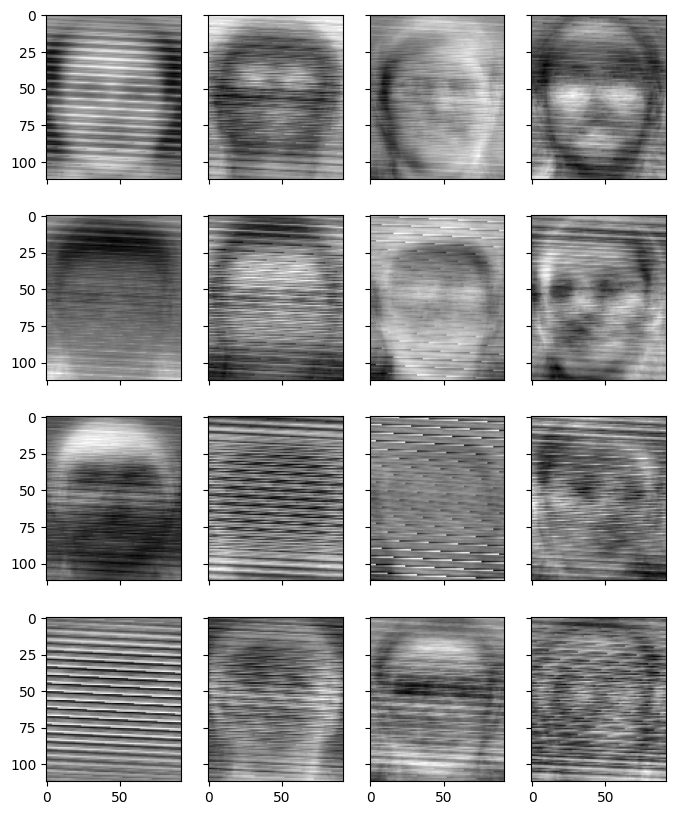

In [589]:
# Take the first k-principal components as eigenfaces
n_components = 40
eigenfaces = pca.components_[:n_components]

# Show the first 16 eigenfaces
fig, axes = plt.subplots(4, 4, sharex=True, sharey=True, figsize=(8,10))
for i in range(len(eigenfaces[:16])):
    axes[i%4][i//4].imshow(eigenfaces[i].reshape(face_shape), cmap="gray")
plt.show()

From this picture, we can see eigenfaces are blurry faces, but indeed each eigenfaces holds some facial characteristics that can be used to build a picture.

Since our goal is to build a face recognition system, we first calculate the weight vector for each input picture:

In [590]:
# Generate weights as a KxN matrix where K is the number of eigenfaces and N the number of samples.
weights = eigenfaces @ (facematrix - pca.mean_).T

The above code is using matrix multiplication to replace loops. Up to here, our face recognition system has been completed. We used pictures of 39 persons to build our eigenface. We use the test picture that belongs to one of these 39 persons (the one held out from the matrix that trained the PCA model) to see if it can successfully recognize the face:

Best match s39 with Euclidean distance 1251.501588


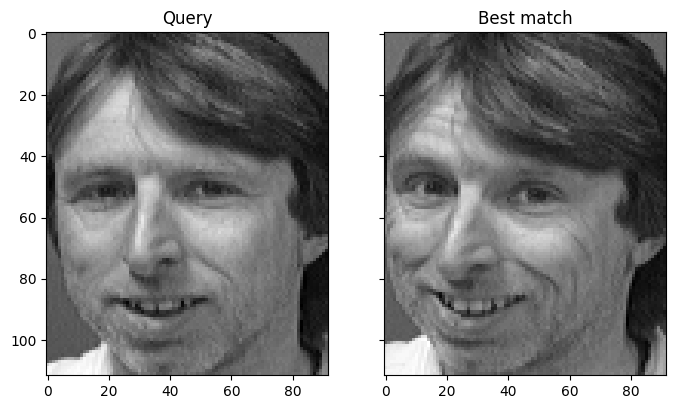

In [591]:
# Test on out-of-sample image of existing class
query = faces["s39/10.pgm"].reshape(1, -1)
query_weight = eigenfaces @ (query - pca.mean_).T
euclidean_distance = np.linalg.norm(weights - query_weight, axis=0)
# print(min(euclidean_distance))
best_match = np.argmin(euclidean_distance)

print("Best match %s with Euclidean distance %f" % (facelabel[best_match], euclidean_distance[best_match]))
# Visualize
fig, axes = plt.subplots(1,2,sharex=True,sharey=True, figsize=(8,6))
axes[0].imshow(query.reshape(face_shape), cmap="gray")
axes[0].set_title("Query")
axes[1].imshow(facematrix[best_match].reshape(face_shape), cmap="gray")
axes[1].set_title("Best match")
plt.show()

Similarity score: 241.78135575188531
The match is good based on the similarity score.


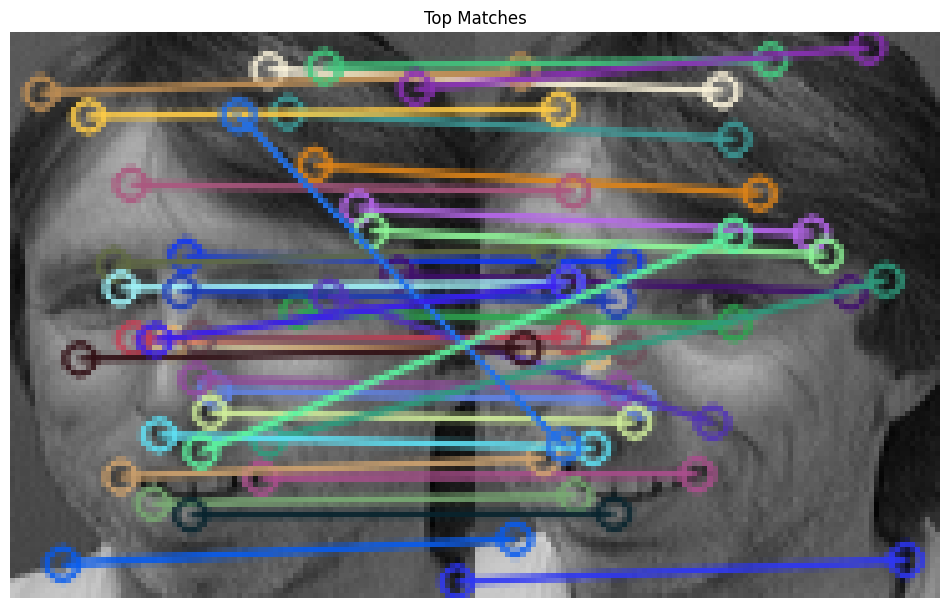

In [592]:
def is_good_match(score, threshold=250):
    return score < threshold

sift = cv2.SIFT_create()
# Find keypoints and descriptors for both images

query_image = query.reshape(face_shape)
best_match_image = facematrix[best_match].reshape(face_shape)

keypoints_query, descriptors_query = sift.detectAndCompute(query_image, None)
keypoints_match, descriptors_match = sift.detectAndCompute(best_match_image, None)

# Initialize nearest neighbor matcher
matcher = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)

# Perform nearest neighbor matching
matches = matcher.match(descriptors_query, descriptors_match)

# Sort matches based on distance (closest matches first)
matches = sorted(matches, key=lambda x: x.distance)

# Calculate similarity score based on matched keypoints
similarity_score = sum([match.distance for match in matches]) / len(matches)
print(f'Similarity score: {similarity_score}')

# Check if the similarity score is below the threshold
if is_good_match(similarity_score):
    print("The match is good based on the similarity score.")
else:
    print("The match is not good based on the similarity score.")

# Draw top matches (optional, for visualization)
num_matches_to_draw = 50
matched_image = cv2.drawMatches(query_image, keypoints_query, best_match_image, keypoints_match, matches[:num_matches_to_draw], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# Display the matched image using matplotlib
plt.figure(figsize=(12, 8))
plt.imshow(cv2.cvtColor(matched_image, cv2.COLOR_BGR2RGB))
plt.title('Top Matches')
plt.axis('off')
plt.show()

# Calculate similarity score based on matched keypoints (optional)
similarity_score = sum([match.distance for match in matches]) / len(matches)
# print(f'Similarity score: {similarity_score}')

Best match s5 with Euclidean distance 2273.024587


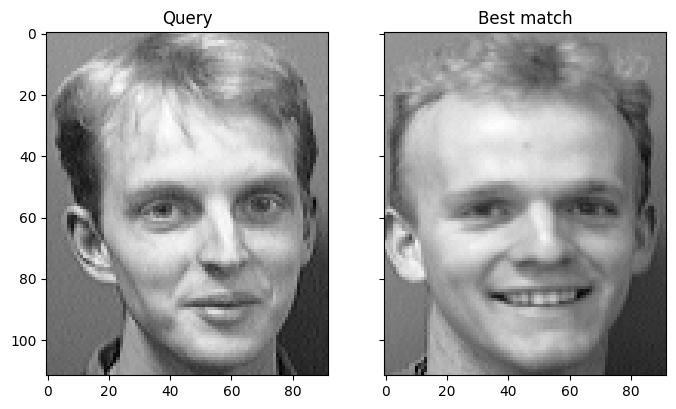

In [593]:
# Test on out-of-sample image of existing class
query = faces["s40/1.pgm"].reshape(1, -1)
query_weight = eigenfaces @ (query - pca.mean_).T
euclidean_distance = np.linalg.norm(weights - query_weight, axis=0)
# print(min(euclidean_distance))
best_match = np.argmin(euclidean_distance)

print("Best match %s with Euclidean distance %f" % (facelabel[best_match], euclidean_distance[best_match]))
# Visualize
fig, axes = plt.subplots(1,2,sharex=True,sharey=True, figsize=(8,6))
axes[0].imshow(query.reshape(face_shape), cmap="gray")
axes[0].set_title("Query")
axes[1].imshow(facematrix[best_match].reshape(face_shape), cmap="gray")
axes[1].set_title("Best match")
plt.show()